# House Prices: Advanced Regression Techniques

## Objective
Predict residential home prices in Ames, Iowa using structured data and ML models. Focus is on modeling complex, non-linear relationships between house features and sale price.

## Dataset Overview
- **79 features** covering property details.
- **Numerical:** LotArea, GrLivArea, TotalBsmtSF, GarageArea, FullBath, etc.
- **Categorical:** Neighborhood, MSZoning, RoofStyle, CentralAir, etc.
- **Target:** SalePrice (USD).

## Approach
1. **Data Exploration & Cleaning:** Handle missing values, encode categorical variables.
2. **Baseline Models:** Decision Tree, Random Forest, XGBoost.
3. **Hyperparameter Tuning:** Optimize Random Forest and XGBoost.
4. **Model Evaluation:** Compare MAE, RMSE, R² on validation set.
5. **Final Prediction:** XGBoost baseline retrained on full data.
6. **Visualization:** Three visualizations included Feature importance,Residuals vs Predicted Values (Validation Set), Predicted vs Actual (Validation Set)

## Results Summary
| Model                  | MAE       | RMSE      | R²        | Rank |
|------------------------|-----------|-----------|-----------|------|
| **XGBoost (Baseline)** | 16,788    | 26,125    | 0.911     | 1    |
| XGBoost (Tuned)        | 15,844    | 26,148    | 0.911     | 2    |
| Random Forest (Baseline)| 17,651   | 28,455    | 0.894     | 3    |
| Random Forest (Tuned)  | 18,032    | 31,347    | 0.872     | 4    |
| Decision Tree (Tuned)  | 27,527    | 40,929    | 0.782     | 5    |
| Decision Tree (Baseline)| 29,015   | 43,825    | 0.750     | 6    |

**Insight:** XGBoost baseline outperformed tuned models, proving strong default configurations can be very effective.

## Conclusion
End-to-end ML pipeline for regression tasks. Ensemble methods like **XGBoost** capture complex patterns in tabular data, while preprocessing and feature handling are critical for accurate predictions.


##  Load Training and Testing Data

In [6]:
# importing important libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_absolute_error,r2_score,mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Load training and test data
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Quick look at data
print(train_df.head(5))
print(test_df.head(5))


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

## Data Cleaning & Preprocessing

In [7]:

# Separate numerical and categorical columns (based on train dataset)
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train_df.select_dtypes(include=["object"]).columns

# Handle missing values (numerical -> median, categorical -> mode)
for col in num_cols:
    if col != "SalePrice":  # target ko skip karna hai
        median_val = train_df[col].median()
        train_df[col] = train_df[col].fillna(median_val)
        if col in test_df.columns:
            test_df[col] = test_df[col].fillna(median_val)

for col in cat_cols:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(mode_val)

# Encode categorical columns (fit on train, transform on both train and test)
le = LabelEncoder()
for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col])
    if col in test_df.columns:
        test_df[col] = le.transform(test_df[col])

# Split features and target
X = train_df.drop(["SalePrice", "Id"], axis=1)
y = train_df["SalePrice"]

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Prepare test dataset (drop Id but keep it safe for submission)
test_ids = test_df["Id"]
X_test = test_df.drop(["Id"], axis=1)

print("Train Shape:", X_train.shape)
print("Validation Shape:", X_valid.shape)
print("Test Shape:", X_test.shape)


Train Shape: (1168, 79)
Validation Shape: (292, 79)
Test Shape: (1459, 79)


## BaseLine Model Check

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_valid)
dt_mae = mean_absolute_error(y_valid, dt_preds)
dt_rmse = np.sqrt(mean_squared_error(y_valid, dt_preds))
dt_r2 = r2_score(y_valid, dt_preds)
print("Decision Tree -> MAE:", dt_mae, "RMSE:", dt_rmse, "R2:", dt_r2)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_valid)
rf_mae = mean_absolute_error(y_valid, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_preds))
rf_r2 = r2_score(y_valid, rf_preds)
print("Random Forest -> MAE:", rf_mae, "RMSE:", rf_rmse, "R2:", rf_r2)

# XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_valid)
xgb_mae = mean_absolute_error(y_valid, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_valid, xgb_preds))
xgb_r2 = r2_score(y_valid, xgb_preds)
print("XGBoost -> MAE:", xgb_mae, "RMSE:", xgb_rmse, "R2:", xgb_r2)

Decision Tree -> MAE: 29014.986301369863 RMSE: 43825.097010887475 R2: 0.7496013759865843
Random Forest -> MAE: 17651.310958904112 RMSE: 28455.23457255085 R2: 0.894437296053954
XGBoost -> MAE: 16788.283952268837 RMSE: 26125.44966284438 R2: 0.9110156332795503


## Hypermeter Tuning for 3 Models

In [9]:
# 🔹 Step 2: Parameters to Tune
# Hypermeter Tuning for DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt_param_dist = {
    "max_depth": [5, 10, 20, None],        
    "min_samples_split": [2, 5, 10],    
    "min_samples_leaf": [1, 3, 4, 5]       
}

random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=10,
    cv=5,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1
)

random_search_dt.fit(X_train, y_train)
print("Best Params (Decision Tree):", random_search_dt.best_params_)

best_dt_model = random_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_valid)

dt_tuned_mae = mean_absolute_error(y_valid, y_pred_dt)
dt_tuned_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_dt))
dt_tuned_r2 = r2_score(y_valid, y_pred_dt)

print("===================================")
print("Decision Tree Regressor Predictions After Hyper Tuning")
print("Validation MAE:", dt_tuned_mae)
print("Validation RMSE:", dt_tuned_rmse)
print("Validation R²:", dt_tuned_r2)


# 2. RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf_param_dist = {
    "n_estimators":[100,200,500],
    "max_depth": [10,20, None],        
    "min_samples_split": [2, 5,10],    
    "min_samples_leaf": [1,2,4],
    "max_features":["sqrt", None]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=5,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)
print("Best Params (Random Forest):", random_search_rf.best_params_)

best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_valid)

rf_tuned_mae = mean_absolute_error(y_valid, y_pred_rf)
rf_tuned_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_rf))
rf_tuned_r2 = r2_score(y_valid, y_pred_rf)

print("===================================")
print("Random Forest Regressor Predictions After Hyper Tuning")
print("Validation MAE:", rf_tuned_mae)
print("Validation RMSE:", rf_tuned_rmse)
print("Validation R²:", rf_tuned_r2)


# 3. XGBRegressor
xgb = XGBRegressor(random_state=42)
xgb_param_dist = {
    "n_estimators":[100,200,500],
    "max_depth": [3,5,7,10],
    "learning_rate":[0.01,0.05,0.1,0.3],
    "subsample":[0.6,0.8,1.0],
    "colsample_bytree":[0.6,0.8,1.0],
    "gamma":[0,1,5],
    "reg_alpha":[0,0.01,0.1],
    "reg_lambda":[1,1.5,2]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=5,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)
print("Best Params (XGBoost):", random_search_xgb.best_params_)

best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_valid)

xgb_tuned_mae = mean_absolute_error(y_valid, y_pred_xgb)
xgb_tuned_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))
xgb_tuned_r2 = r2_score(y_valid, y_pred_xgb)

print("===================================")
print("XGB Regressor Predictions After Hyper Tuning")
print("Validation MAE:", xgb_tuned_mae)
print("Validation RMSE:", xgb_tuned_rmse)
print("Validation R²:", xgb_tuned_r2)


Best Params (Decision Tree): {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 20}
Decision Tree Regressor Predictions After Hyper Tuning
Validation MAE: 27526.695850120872
Validation RMSE: 40929.19792215582
Validation R²: 0.7816000001432356
Best Params (Random Forest): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Random Forest Regressor Predictions After Hyper Tuning
Validation MAE: 17426.199760273972
Validation RMSE: 30745.557076990073
Validation R²: 0.8767602244753666
Best Params (XGBoost): {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
XGB Regressor Predictions After Hyper Tuning
Validation MAE: 15336.189292594177
Validation RMSE: 24554.391521580634
Validation R²: 0.9213960232316933


## Results Comparison & Ranking Model 

In [10]:
# Comparing Results of XGB, RF, DT (baseline vs Tuned)
results = pd.DataFrame({
    "Model": [
        "Decision Tree (Baseline)", 
        "Decision Tree (Tuned)",
        "Random Forest (Baseline)",
        "Random Forest (Tuned)",
        "XGBoost (Baseline)",
        "XGBoost (Tuned)"
    ],
    "MAE": [
        dt_mae, dt_tuned_mae, 
        rf_mae, rf_tuned_mae, 
        xgb_mae, xgb_tuned_mae
    ],
    "RMSE": [
        dt_rmse, dt_tuned_rmse, 
        rf_rmse, rf_tuned_rmse, 
        xgb_rmse, xgb_tuned_rmse
    ],
    "R2": [
        dt_r2, dt_tuned_r2, 
        rf_r2, rf_tuned_r2, 
        xgb_r2, xgb_tuned_r2
    ]
})

print(results.to_string())

#Ranking Models
results["MAE_Rank"] = results["MAE"].rank(ascending=True)
results["RMSE_Rank"] = results["RMSE"].rank(ascending=True)
results["R2_Rank"] = results["R2"].rank(ascending=False)

results["Overall_Rank"] = results[["MAE_Rank","RMSE_Rank","R2_Rank"]].sum(axis=1)

results_sorted = results.sort_values("Overall_Rank")
print(results_sorted.to_string())

best_model = results_sorted.iloc[0]["Model"]
print("\n🏆 Best Model:", best_model)


                      Model           MAE          RMSE        R2
0  Decision Tree (Baseline)  29014.986301  43825.097011  0.749601
1     Decision Tree (Tuned)  27526.695850  40929.197922  0.781600
2  Random Forest (Baseline)  17651.310959  28455.234573  0.894437
3     Random Forest (Tuned)  17426.199760  30745.557077  0.876760
4        XGBoost (Baseline)  16788.283952  26125.449663  0.911016
5           XGBoost (Tuned)  15336.189293  24554.391522  0.921396
                      Model           MAE          RMSE        R2  MAE_Rank  RMSE_Rank  R2_Rank  Overall_Rank
5           XGBoost (Tuned)  15336.189293  24554.391522  0.921396       1.0        1.0      1.0           3.0
4        XGBoost (Baseline)  16788.283952  26125.449663  0.911016       2.0        2.0      2.0           6.0
2  Random Forest (Baseline)  17651.310959  28455.234573  0.894437       4.0        3.0      3.0          10.0
3     Random Forest (Tuned)  17426.199760  30745.557077  0.876760       3.0        4.0      4.0   

## Final Tuning On Xgboost(Baseline)

In [11]:
# Combine train + valid for final training
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

# Fit the final baseline XGBoost model
xgb_baseline_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_baseline_model.fit(X_train_full, y_train_full)

# Predict on test set
y_test_pred_baseline = xgb_baseline_model.predict(X_test)

# Print predictions
print("XGBoost Baseline Predictions on Test Set (First 5):")
print(y_test_pred_baseline[:5])


XGBoost Baseline Predictions on Test Set (First 5):
[123062.47 155810.42 189642.81 186816.34 186859.77]


## VISUALIZATIONS

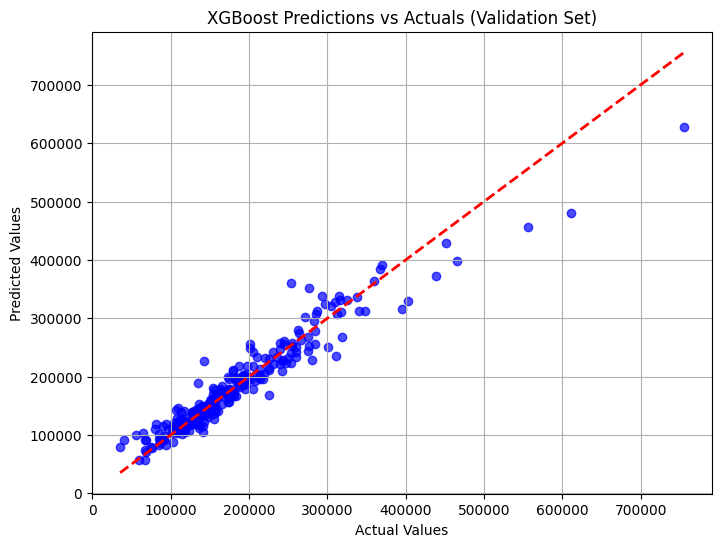

In [12]:
# -----------------------------
# 1. Predicted vs Actual (Validation Set)
# -----------------------------
xgb_val_preds = best_xgb_model.predict(X_valid)

plt.figure(figsize=(8,6))
plt.scatter(y_valid, xgb_val_preds, alpha=0.7, color='blue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Predictions vs Actuals (Validation Set)")
plt.grid(True)
plt.show()



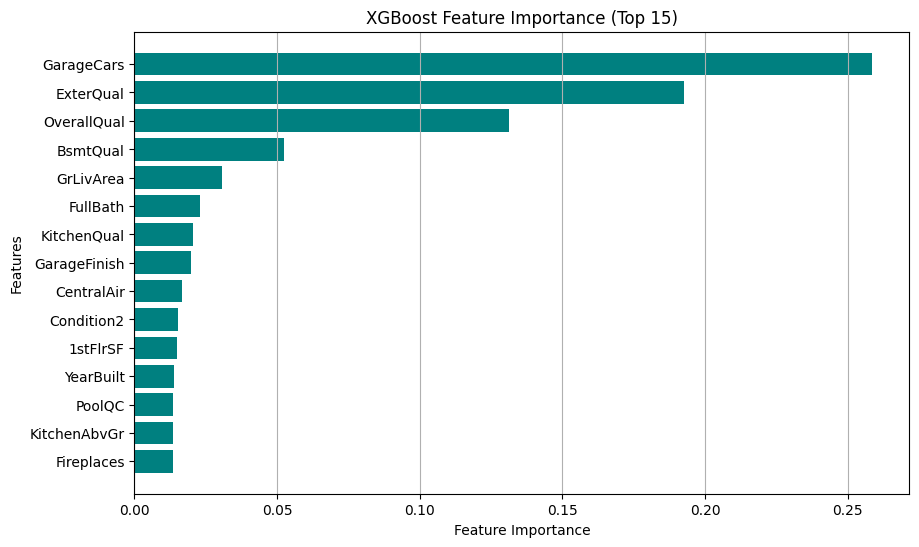

In [13]:
# -----------------------------
# 2. Feature Importance (Top 15 Features)
# -----------------------------
xgb_importance = best_xgb_model.feature_importances_
top_idx = np.argsort(xgb_importance)[-15:]  # Top 15 features

plt.figure(figsize=(10,6))
plt.barh(X_train.columns[top_idx], xgb_importance[top_idx], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Top 15)")
plt.grid(axis='x')
plt.show()

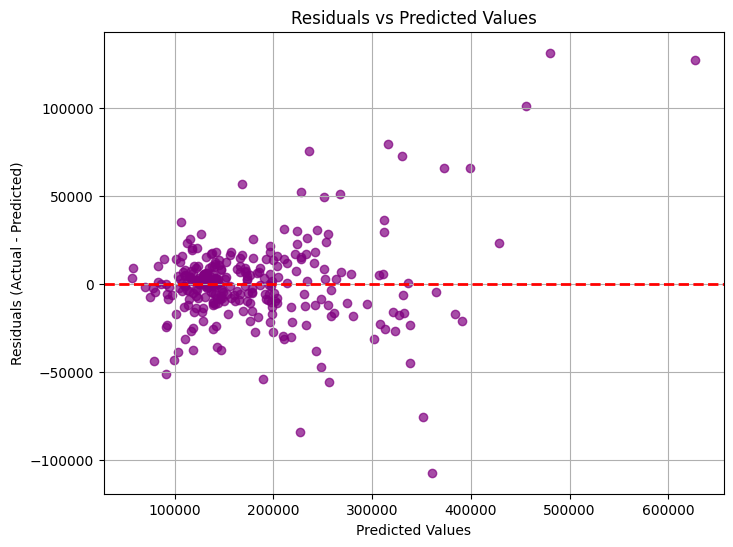

In [14]:

# -----------------------------
# 3. Residuals vs Predicted Values (Validation Set)
# -----------------------------
errors = y_valid - xgb_val_preds

plt.figure(figsize=(8,6))
plt.scatter(xgb_val_preds, errors, alpha=0.7, color='purple')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()

## Final Submission.csv

In [15]:
# Assuming you loaded the test CSV as test_df
submission = pd.DataFrame({
    "Id": test_df["Id"],          
    "SalePrice": y_test_pred_baseline
})

submission.to_csv("xgboost_submission_house_prices_prediction.csv", index=False)
print("CSV saved correctly!")

CSV saved correctly!
